In [7]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import h5py
%matplotlib inline

mat_names = glob.glob('./project_datasets/*.mat')
# each test subject got a different file - 9 test subjects
print(mat_names)

['./project_datasets/A01T_slice.mat', './project_datasets/A02T_slice.mat', './project_datasets/A03T_slice.mat', './project_datasets/A04T_slice.mat', './project_datasets/A05T_slice.mat', './project_datasets/A06T_slice.mat', './project_datasets/A07T_slice.mat', './project_datasets/A08T_slice.mat', './project_datasets/A09T_slice.mat']


In [8]:
matfile = h5py.File(mat_names[0], 'r')
print(matfile.keys()) #image and type

[u'image', u'type']


In [9]:
image_mat = matfile['image']
image_shape = image_mat.shape # 288 (48x6) trials across 25 electrodes for 1000 time points (250Hz*4s)
print image_shape

(288, 25, 1000)


In [10]:
type_mat = matfile['type']
type_shape = type_mat.shape
print type_shape
# plt.plot(type_mat[0,:288]) # gets the significant values of types
# all the 0's occur after 288, and are meaningless I think
# so the image_mat, which has shape (288, 25, 1000) should correspond
# to the first 288 entries of type_mat, so
# for a single subject, training data should be image_mat, with 288 samples, each sample has shape (25, 1000)
# and our target label matrix should be type_mat[:288] (or 287?)

(1, 1000)


In [11]:
nans = np.sum(np.isnan(image_mat[:,:]))
print(nans) #No NaN in the data

48


In [12]:
type_set = set(type_mat[0,:])
print(type_set) 

set([0.0, 769.0, 770.0, 771.0, 772.0])


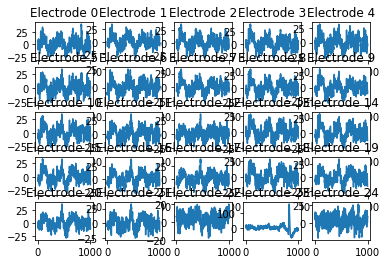

In [13]:
for i in range(image_shape[1]):
    plt.subplot(image_shape[1]**0.5,image_shape[1]**0.5,i+1)
    plt.plot(matfile['image'][0,i,:])
    plt.title("Electrode " + str(i))
    plt.rcParams["figure.figsize"] = [20,20]

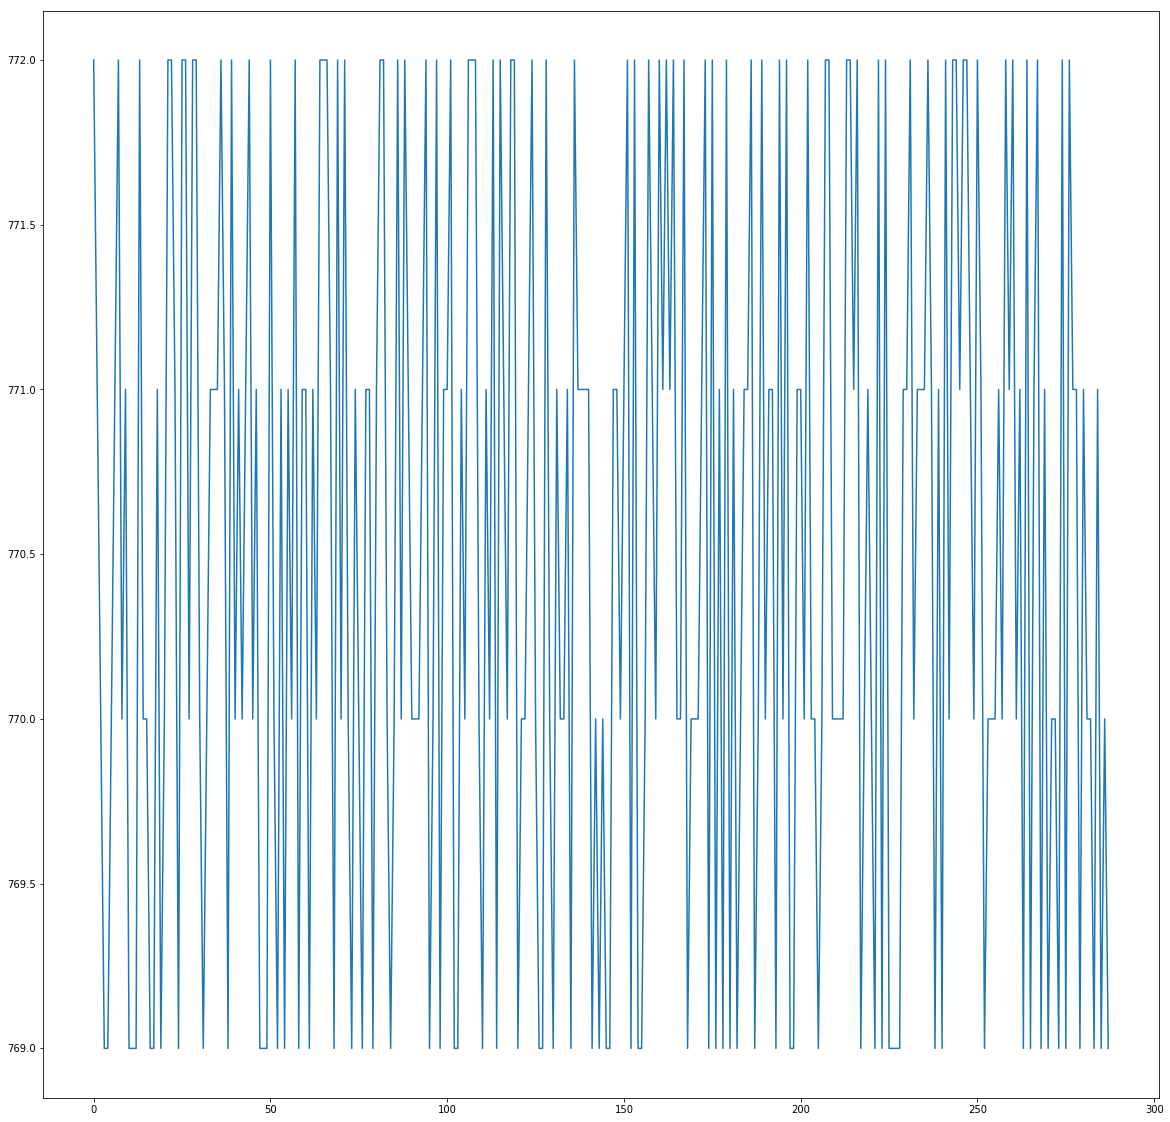

In [14]:
plt.plot(matfile['type'][0,:image_shape[0]])

In [15]:
EEG_channels = 22 #from project guidelines
test_count = 50 #from project guideline, 238 for train-validation and 50 for test
validation_count = 38 # 38 points in validation set and remaining 200 points in test set

In [16]:
#setting seed
np.random.seed(seed=1337)
test_picked = np.random.choice(image_shape[0], test_count, replace=False)
train_val_picked = np.setdiff1d(np.arange(image_shape[0]), test_picked)
val_picked = train_val_picked[:validation_count]
train_picked = train_val_picked[validation_count:]

In [17]:
trainval_data_X = []
training_data_X = []
validation_data_X = []
test_data_X = []

trainval_data_Y = []
training_data_Y = []
validation_data_Y = []
test_data_Y = []

for i in range(len(mat_names)):
    matfile = h5py.File(mat_names[i], 'r')
    
    trainval_data_X.append(matfile['image'][sorted(train_val_picked),:EEG_channels,:]) #(238, 22, 1000) x 9
    training_data_X.append(matfile['image'][sorted(train_picked),:EEG_channels,:]) #(200, 22, 1000) x 9
    validation_data_X.append(matfile['image'][sorted(val_picked),:EEG_channels,:]) #(38, 22, 1000) x 9
    test_data_X.append(matfile['image'][sorted(test_picked),:EEG_channels,:]) #(50, 22, 1000) x 9
    
    trainval_data_Y.append(matfile['type'][0,sorted(train_val_picked)]) #(238, ) x 9
    training_data_Y.append(matfile['type'][0,sorted(train_picked)]) #(200, ) x 9
    validation_data_Y.append(matfile['type'][0,sorted(val_picked)]) #(38, ) x 9
    test_data_Y.append(matfile['type'][0,sorted(test_picked)]) #(50, ) x 9

In [18]:
for i in range(len(mat_names)):
    assert(set(training_data_Y[i]) == set(validation_data_Y[i])) #check whether we have data for all labels 
    assert(set(training_data_Y[i]) == set(test_data_Y[i])) #check whether we have data for all labels 

In [19]:
training_data_shape = training_data_X[0].shape
print(training_data_shape) #(200, 22, 1000) while test data shape is (50, 22, 1000) and validation data is (38, 22,1000)

(200, 22, 1000)


In [20]:
print(training_data_Y[0].shape)

(200,)


In [21]:
from functools import reduce
cnn_trainval_data_X = reduce((lambda x, y: np.concatenate((x, y), axis=0)), trainval_data_X) #(2142, 22, 1000) 
cnn_training_data_X = reduce((lambda x, y: np.concatenate((x, y), axis=0)), training_data_X) #(1800, 22, 1000)
cnn_validation_data_X = reduce((lambda x, y: np.concatenate((x, y), axis=0)), validation_data_X) #(342, 22, 1000)
cnn_test_data_X = reduce((lambda x, y: np.concatenate((x, y), axis=0)), test_data_X) #(450, 22, 1000)

cnn_trainval_data_Y = reduce((lambda x, y: np.concatenate((x, y), axis=0)), trainval_data_Y) #(2142, )
cnn_training_data_Y = reduce((lambda x, y: np.concatenate((x, y), axis=0)), training_data_Y) #(1800, )
cnn_validation_data_Y = reduce((lambda x, y: np.concatenate((x, y), axis=0)), validation_data_Y) #(342, )
cnn_test_data_Y = reduce((lambda x, y: np.concatenate((x, y), axis=0)), test_data_Y) #(450,)



In [22]:
print cnn_trainval_data_X.shape
print cnn_trainval_data_Y.shape

(2142, 22, 1000)
(2142,)


In [46]:
import torch.nn as nn
from torch.autograd import Variable
import torch

# Hyper Parameters
num_epochs = 5
batch_size = 100
learning_rate = 0.001

# # MNIST Dataset
# train_dataset = dsets.MNIST(root='./data/',
#                             train=True, 
#                             transform=transforms.ToTensor(),
#                             download=True)

# test_dataset = dsets.MNIST(root='./data/',
#                            train=False, 
#                            transform=transforms.ToTensor())

# Data Loader (Input Pipeline)
# train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
#                                            batch_size=batch_size, 
#                                            shuffle=True)

# test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
#                                           batch_size=batch_size, 
#                                           shuffle=False)

# train_concat = np.hstack((cnn_trainval_data_X, cnn_trainval_data_Y.reshape(2142,1)))
# test_concat = np.append(cnn_test_data_X, cnn_test_data_Y, 1)

# print train_concat.shape
# print test_concat.shape

In [47]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv1d(22, 128, kernel_size=5, padding=2, stride=7, dilation=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2))
#         self.layer2 = nn.Sequential(
#             nn.Conv2d(16, 32, kernel_size=5, padding=2),
#             nn.BatchNorm2d(32),
#             nn.ReLU(),
#             nn.MaxPool2d(2))
        self.fc = nn.Linear(9088, 4)
        
    #basic forward - go through two conv layers + fc layer
    def forward(self, x):
        out = self.layer1(x)
#         out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [48]:
import torch

cnn = CNN()

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)
i = 0            
for epoch in range(num_epochs):
#     for i in range(cnn_training_data_X.shape[0]):
    images = Variable(tensor_x_train, requires_grad=True) #unsqueeze used to make a 4d tensor because 
#     print images.shape
    labels = Variable(tensor_y_train, requires_grad=True).long

    # Forward + Backward + Optimize
    optimizer.zero_grad()
    outputs = cnn(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

#     if (i+1) % 100 == 0:
    print ('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f' 
           %(epoch+1, num_epochs, i+1, len(cnn_training_data_X.shape[0])//batch_size, loss.data[0]))


# FIX THIS
# Test the Model
cnn.eval()  # Change model to 'eval' mode (BN uses moving mean/var).
correct = 0
total = 0
for images, labels in test_loader:
    images = Variable(images)
    outputs = cnn(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Test Accuracy of the model on the 10000 test images: %d %%' % (100 * correct / total))

AttributeError: 'function' object has no attribute 'requires_grad'

In [35]:
tensor_x_train = torch.Tensor(cnn_training_data_X)
tensor_y_train = torch.Tensor(cnn_training_data_Y)

print tensor_x_train.shape
print tensor_y_train.shape

torch.Size([1800, 22, 1000])
torch.Size([1800])
